This Jupyter Notebook contains code to do the following:
- Clean EAGLE-I Data
- Extract County Events from EAGLE-I Data
- Extract Multi-County events based on space and time

The notebook is divided into sections and each code block is suplemented with comments and markdown text to guide the user about whats going on.

All or parts of the code from this notebook can be easily copied to create standalone python script files.
Further information about the methods used in this notebook can be found in the following papers:
- https://arxiv.org/abs/2511.12685
- 


# Initialization

This section contains the code to load libraries and do some housekeeping of the EAGLE-I files.  
The code is currently desinged to work for one state at a time, so the state name is defined in this section to load the data (with some initial cleaning).

In [14]:
# importing necessary libraries
import os
import sys
import re
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from src.eaglei_modules.eagleiEventProcessing import verify_eaglei_files, EagleiStateProcessor

In [16]:
# code to set up matplotlib and seaborn styles

plt.style.use('default')

# Save the default rcParams to revert back if needed
dflt_rcParams = mpl.rcParams.copy()

# Change the default font
mpl.rcParams.update({'font.family': 'sans-serif', 'font.sans-serif': ['Arial']})

# Increase the font size for better readability
mpl.rcParams.update({'font.size': 14, 
                     'axes.titlesize': 14,
                     'axes.titleweight': 'bold', 
                     'axes.labelsize': 12,
                     'axes.labelweight': 'bold',
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12, 
                     'legend.fontsize': 11})

# Remove the top and right spines for a cleaner look
mpl.rcParams.update({'axes.spines.right': False, 
                     'axes.spines.top': False,
                     'axes.spines.left': True,
                     'axes.spines.bottom': True})

# Add space between the plot and the title
mpl.rcParams.update({'axes.titlepad': 15})

# Set the figure size for all plots
mpl.rcParams.update({'figure.figsize': (10, 6)})

# Set the style for seaborn
sns.set_style("white")  # other options: "dark", "whitegrid", "darkgrid", "ticks"

In [17]:
# verify that EAGLEi files are present
eaglei_files = verify_eaglei_files()

Found EAGLEi outage data files for 11 years: 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024


In [18]:
# Load EAGLEi data for a specific state if already cleaned, else Load and Clean it (takes almost a minute)
state_data = EagleiStateProcessor(state_name="Massachusetts")

Cleaned data for Massachusetts already exists as eaglei_cleaned_massachusetts.parquet. Loading the existing file...


In [19]:
state_data.eaglei_df.head()

,fips_code,county,state,run_start_time,customers_out
0,25001,Barnstable,Massachusetts,2014-11-01 04:00:00,1
1,25009,Essex,Massachusetts,2014-11-01 04:00:00,1
2,25027,Worcester,Massachusetts,2014-11-01 04:00:00,1
3,25001,Barnstable,Massachusetts,2014-11-01 04:15:00,1
4,25009,Essex,Massachusetts,2014-11-01 04:15:00,1


In [20]:
state_data.county_wide_customers.head()

,fips_code,county,total_customers
0,25025,Suffolk,1666496
1,25017,Middlesex,807605
2,25021,Norfolk,646684
3,25023,Plymouth,608164
4,25005,Bristol,581443


# County-level Analysis

This section contain code to clean data for individual counties and extract County-level events.  
If you want to work on a single county then all the relevant code is available in this section.

# State-level Analysis

## Counties Adjaceny Graph

A county adjacency graph is required to to use the spatiotemporal events grouping. This section contains the code to visualize the adjancecy graph of the current state, which is automatically generated when the state object is created. Sometime, we can assume two counties to be neighbors event if they don't share a border, such cases are also addressed in this section.

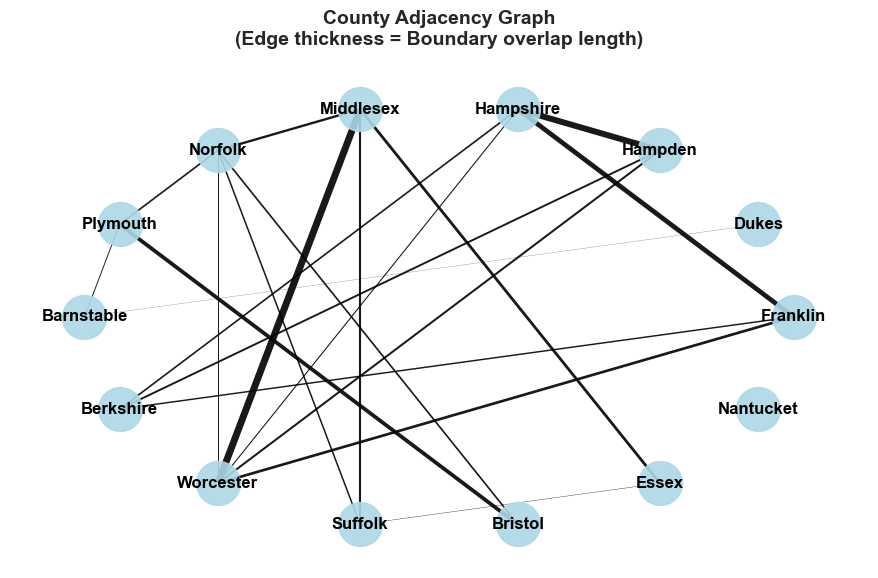

In [21]:
# Visualize the adjacency graph of counties in the state
from src.eaglei_modules.eagleiEventProcessing import visualize_county_graph
visualize_county_graph(state_data.county_adjacency_graph)

In [22]:
# Analyze the graph structure
from src.eaglei_modules.eagleiEventProcessing import analyze_county_graph
analyze_county_graph(state_data.county_adjacency_graph)

County Adjacency Graph Statistics:
Number of counties (nodes): 14
Number of adjacencies (edges): 20
Average degree: 2.86

County with most neighbors: Norfolk (5 neighbors)
County with least neighbors: Nantucket (0 neighbors)

Longest shared boundary: Middlesex - Worcester
Boundary length: 114.64 km


In [23]:
# Manually add edges between counties (that do not share common borders but we think should 
# be considered as neighbours) with zero edge weight and zero border length (to indicate a special case)
state_data.add_edge_to_county_adjacency_graph('Barnstable', 'Nantucket', edge_weight=0, border_length=0)
state_data.add_edge_to_county_adjacency_graph('Dukes', 'Nantucket', edge_weight=0, border_length=0)

Added an additional edge from Barnstable to Nantucket with weight 0 and border length 0 to the county adjacency graph.
Added an additional edge from Dukes to Nantucket with weight 0 and border length 0 to the county adjacency graph.


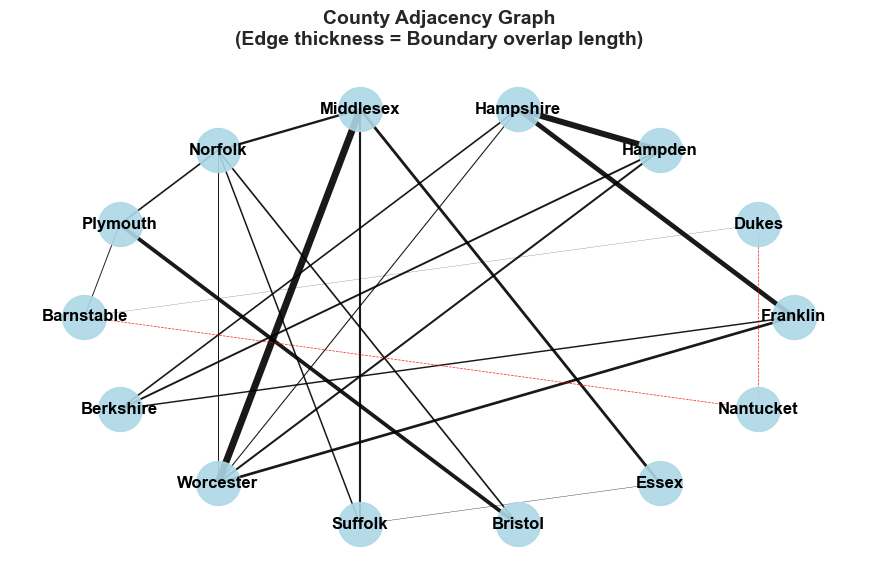

In [24]:
# Visualize the updated adjacency graph
visualize_county_graph(state_data.county_adjacency_graph)

In [25]:
# We can also access specific information about the graph
print("Counties and their neighbors:")
for county in state_data.county_adjacency_graph.nodes():
    neighbors = list(state_data.county_adjacency_graph.neighbors(county))
    print(f"{county}: {neighbors}")

Counties and their neighbors:
Franklin: ['Hampshire', 'Berkshire', 'Worcester']
Dukes: ['Barnstable', 'Nantucket']
Hampden: ['Hampshire', 'Berkshire', 'Worcester']
Hampshire: ['Franklin', 'Hampden', 'Berkshire', 'Worcester']
Middlesex: ['Norfolk', 'Worcester', 'Suffolk', 'Essex']
Norfolk: ['Middlesex', 'Plymouth', 'Worcester', 'Suffolk', 'Bristol']
Plymouth: ['Norfolk', 'Barnstable', 'Bristol']
Barnstable: ['Dukes', 'Plymouth', 'Nantucket']
Berkshire: ['Franklin', 'Hampden', 'Hampshire']
Worcester: ['Franklin', 'Hampden', 'Hampshire', 'Middlesex', 'Norfolk']
Suffolk: ['Middlesex', 'Norfolk', 'Essex']
Bristol: ['Norfolk', 'Plymouth']
Essex: ['Middlesex', 'Suffolk']
Nantucket: ['Barnstable', 'Dukes']


In [26]:
# Example: Find shortest path between two counties
from src.eaglei_modules.eagleiEventProcessing import shortest_path_between_counties
shortest_path_between_counties(state_data.county_adjacency_graph, 'Suffolk', 'Bristol')

Shortest path from Suffolk to Bristol: Suffolk -> Norfolk -> Bristol
Total boundary overlap distance: 52.89 km


## Events based on Time and Location

This section contain the code and results for extracting events based on both time and space.

In [27]:
# Automatically process all counties in the state, performing cleaning, 
# and county-level event detection with a threshold of 30 customers,
# it takes around 1-2 minutes to process all counties in a state like Massachusetts
state_data.auto_process_all_counties(ac_customers_threshold=30)


Processing County: Barnstable
Total Data Points in EAGLEi: 1897008
Total Data Points in EAGLEi (Barnstable): 147675 (7.78%)
Found 853 significant gaps (gap duration <= 1440 minutes, AND at least 10 customers before gap, AND at least 2 customers after gap)
Ranking method used: customer_weighted
Selected quantile: 0.44

Data gap filling completed:
  New Gap-filled records created: 1116
Total Events Created (AC with Threshold = 30): 15991

Processing County: Essex
Total Data Points in EAGLEi: 1897008
Total Data Points in EAGLEi (Essex): 183033 (9.65%)
Found 1647 significant gaps (gap duration <= 1440 minutes, AND at least 10 customers before gap, AND at least 2 customers after gap)
Ranking method used: customer_weighted
Selected quantile: 0.54

Data gap filling completed:
  New Gap-filled records created: 1772
Total Events Created (AC with Threshold = 30): 18197

Processing County: Worcester
Total Data Points in EAGLEi: 1897008
Total Data Points in EAGLEi (Worcester): 213035 (11.23%)
Fou

Once the auto_process_all_counties function is executed, a new dataframe *all_counties_events_df* is created in state_data object.  
The dataframe contains the cleaned data for all the counties in the state, along with following additional columns:
- **filled_gap**: this is a binary variable which indicates if there is a *significant* data gap between the current and the subsequent value. If the value is None, it means there is no *significant* data gap. If the value is False, it means there is a significant data gap that is identified but left unfilled as it didn't match the gap filling criteria. If the value is True, it means the gap is filled and new records are created based on that in the data.
- **event_number_ac_threshold_##**: this column contains the county-level event numbers. The ## suffix indicates the threshold used for the minimum number of customers in the event extraction algorithm.
- **event_number_temporal**: this column contains the event numbers corresponding to the temporal grouping of county events, i.e., all the rows corresponding to a certain temporal event number would be all the outages that overlap in time and occurred in one or more than one counties within the state.

In [28]:
state_data.all_counties_events_df.head()

,fips_code,county,state,run_start_time,customers_out,filled_gap,event_number_ac_threshold_30,event_number_temporal
0,25027,Worcester,Massachusetts,2014-11-01 06:45:00,58,None,45256,1
1,25027,Worcester,Massachusetts,2014-11-01 07:00:00,58,None,45256,1
2,25027,Worcester,Massachusetts,2014-11-01 07:15:00,57,None,45256,1
3,25027,Worcester,Massachusetts,2014-11-01 07:30:00,57,None,45256,1
4,25027,Worcester,Massachusetts,2014-11-01 07:45:00,57,None,45256,1


In [30]:
# We can select any temporal event id and run the spatiotemporal event grouping algorithm
# to see how that event is seperated into multiple events based on both the location and time overlap.
state_data.save_spatiotemporal_event_plots(temporal_event_id=1)

11 spatiotemporal events created
Saved plots to /Users/arslanahmad/Library/CloudStorage/Dropbox/CFA/CFAARSLAN/EAGLEi/Outage_Analysis_eaglei/Results/plots_of_event_1.pdf
Saved plots to /Users/arslanahmad/Library/CloudStorage/Dropbox/CFA/CFAARSLAN/EAGLEi/Outage_Analysis_eaglei/Results/curves_of_event_1.pdf


In [ ]:
# Checking the number of records in each temporal event to see the largest events
state_data.all_counties_events_df.event_number_temporal.value_counts()

event_number_temporal
3361    6936
8865    5918
5712    5402
6886    5071
7925    4174
        ... 
340        1
5376       1
6390       1
3242       1
7571       1
Name: count, Length: 9263, dtype: int64